In [1]:
%%bash
pip install timm -q
pip install onnx -q
pip install onnxruntime -q

In [2]:
import os
import sys
import cv2
import onnx
import timm
import torch
import random as r
import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt

from typing import Union
from torchvision import models
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
labels: dict = {
    0 : "cup",
    1 : "fork",
    2 : "glass",
    3 : "knife",
    4 : "plate",
    5 : "spoon"
}
    

def breaker() -> None:
    print("\n" + 50*"*" + "\n")

    
def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_image(image: np.ndarray, cmap: str="gnuplot2", title: Union[str, None]=None) -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.model = timm.create_model(model_name="efficientnet_b4", pretrained=False)
        self.model.classifier = torch.nn.Linear(in_features=self.model.classifier.in_features, out_features=6)

    def forward(self, x):
        return self.model(x)


class CFG(object):  
    def __init__(self, 
             in_channels: int=3, 
             size: int=256, 
             opset_version: int=9, 
             path: str=None):
        self.in_channels = in_channels
        self.size = size
        self.dummy = torch.randn(1, self.in_channels, self.size, self.size)
        self.opset_version = opset_version
        self.path = path

In [5]:
cfg = CFG(
    in_channels=3, 
    size=384, 
    opset_version=13, 
    path="/kaggle/input/kc-en4-a384-e10/saves/ble_state_fold_2.pt"
)


model = Model()
model.load_state_dict(torch.load(cfg.path, map_location=torch.device("cpu"))["model_state_dict"])
model.eval()

clear_output()

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

breaker()
print(f"Model size: {size_all_mb:.3f} MB")
breaker()


**************************************************

Model size: 67.462 MB

**************************************************



In [6]:
torch.onnx.export(
    model=model, 
    args=cfg.dummy, 
    f="kc-en4-f2.onnx", 
    input_names=["input"], 
    output_names=["output"], 
    opset_version=cfg.opset_version,
    export_params=True,
    training=torch.onnx.TrainingMode.EVAL,
    operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK,
    dynamic_axes={
      "input"  : {0 : "batch_size"},
      "output" : {0 : "batch_size"},
    }
)

In [7]:
class OnnxModel(object):
    def __init__(self) -> None:
        self.ort_session = None
        self.size: int = 384
            
        # self.mean: list = [0.5, 0.5, 0.5]
        # self.std: list  = [0.5, 0.5, 0.5]
        
        self.mean: list = [0.52184, 0.47946, 0.43919]
        self.std: list  = [0.17009, 0.17413, 0.17846]
        
        self.path: str = "kc-en4-f2.onnx"

        ort.set_default_logger_severity(3)
    
    def setup(self) -> None:
        model = onnx.load(self.path)
        onnx.checker.check_model(model)
        self.ort_session = ort.InferenceSession(self.path)
    
    def infer(self, image: np.ndarray, labels: dict) -> np.ndarray:
        h, w, _ = image.shape

        image = image / 255
        image = cv2.resize(src=image, dsize=(self.size, self.size), interpolation=cv2.INTER_AREA).transpose(2, 0, 1)
        for i in range(image.shape[0]): image[i, :, :] = (image[i, :, :] - self.mean[i]) / self.std[i]
        image = np.expand_dims(image, axis=0)
        input = {self.ort_session.get_inputs()[0].name : image.astype("float32")}
        return labels[np.argmax(self.ort_session.run(None, input))].title()

    
onnx_model = OnnxModel()
onnx_model.setup()


**************************************************



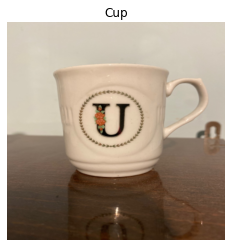


**************************************************



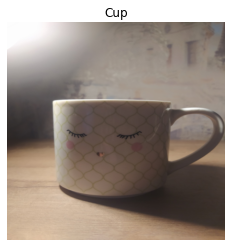


**************************************************



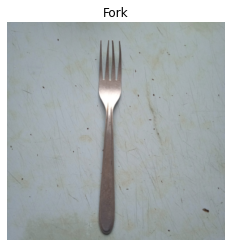


**************************************************



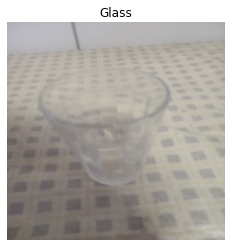


**************************************************



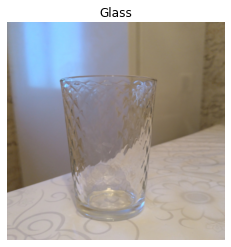


**************************************************



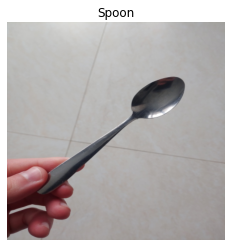


**************************************************



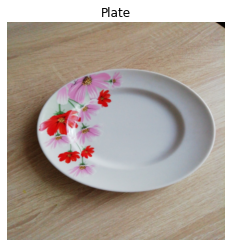


**************************************************



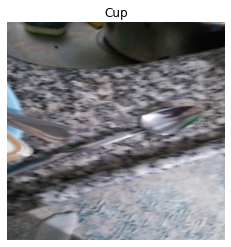


**************************************************



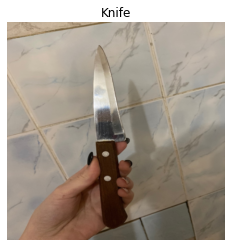


**************************************************



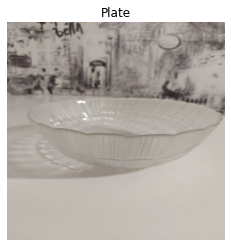


**************************************************



In [8]:
df = pd.read_csv("/kaggle/input/kc-dataframe/test.csv")

breaker()
for _ in range(10):
    index = r.randint(0, df.shape[0] - 1)
    
    filepath = df.iloc[index, 0]
    
    image = get_image(filepath, cfg.size)
    
    y_pred = onnx_model.infer(image, labels)
    
    show_image(image, title=y_pred)
    
    breaker()